In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ——— GazelleOptimizer with Lévy flight & Brownian motion ——————————
def levy_brownian_step(prob_brownian=0.3, lam=1.5, size=1):
    if np.random.rand() < prob_brownian:
        return np.random.normal(0, 0.1, size)
    else:
        sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
                     (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)
        u = np.random.normal(0, sigma_levy, size)
        v = np.random.normal(0, 1, size)
        return u/(np.abs(v)**(1/lam))

class GazelleOptimizer(optim.Optimizer):
    def __init__(self, params, lr=0.001, momentum=0.9, exploration_factor=0.1,
                 num_gazelles=10, prob_brownian=0.3):
        defaults = dict(lr=lr, momentum=momentum,
                        exploration_factor=exploration_factor,
                        num_gazelles=num_gazelles)
        super().__init__(params, defaults)
        self.prob_brownian = prob_brownian
        self.gazelles = None

    def initialize_population(self, shape, device, dtype):
        lb, ub = -1., 1.
        self.gazelles = torch.empty(
            (self.defaults['num_gazelles'], *shape),
            device=device, dtype=dtype
        ).uniform_(lb, ub)

    def step(self, closure=None):
        loss = closure() if closure else None
        for group in self.param_groups:
            lr = group['lr']
            m = group['momentum']
            ef = group['exploration_factor']
            ng = group['num_gazelles']

            for p in group['params']:
                if p.grad is None: continue
                d = p.grad.data
                shape = d.shape

                if self.gazelles is None or self.gazelles.shape[1:] != shape:
                    self.initialize_population(shape, p.device, p.dtype)

                vec = torch.tensor(
                    levy_brownian_step(self.prob_brownian, size=d.numel()),
                    device=p.device, dtype=p.dtype
                ).view_as(d).detach()

                for i in range(ng):
                    self.gazelles[i].add_(ef * vec).clamp_(-1., 1.)

                buf = self.state[p].get('momentum_buffer', None)
                if buf is None:
                    buf = d.clone()
                    self.state[p]['momentum_buffer'] = buf
                else:
                    buf.mul_(m).add_(d)
                elite = self.gazelles.mean(0)
                p.data.add_( -(buf + ef*elite) * lr )
        return loss

In [7]:
# ——— Data Preparation —————————————————————————————————————————————
dataset_path = r"C:\Users\CVR\Desktop\DataSet\Herlev Dataset\augmented_train"
batch_size, num_classes = 32, 7
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
dataset = datasets.ImageFolder(dataset_path, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def create_model(name, num_classes):
    if name == 'squeezenet1_1':
        model = models.squeezenet1_1(pretrained=True)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
        model.num_classes = num_classes

    elif name == 'resnet18':
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif name == 'vgg16':
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

    elif name == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    else:
        raise ValueError(f"Unsupported model name: {name}")

    return model.to(device)

In [11]:
num_classes = 7  # adjust for your classification problem
model_names = ['squeezenet1_1', 'resnet18', 'vgg16', 'mobilenet_v2']

# Create models with distinct names
models_dict = {}
for name in model_names:
    model = create_model(name, num_classes)
    models_dict[name] = model
# ——— Training & Evaluation Functions —————————————————————————————————
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    return total_loss/total, correct/total

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, all_preds, all_labels = 0, [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            out = model(inputs)
            loss = criterion(out, labels)
            total_loss += loss.item() * inputs.size(0)
            preds = out.argmax(1)
            all_preds += preds.cpu().tolist()
            all_labels += labels.cpu().tolist()

    metrics = {
        'loss': total_loss/len(loader.dataset),
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, average='weighted'),
        'recall': recall_score(all_labels, all_preds, average='weighted'),
        'f1': f1_score(all_labels, all_preds, average='weighted'),
        'mcc': matthews_corrcoef(all_labels, all_preds)
    }
    return metrics

C:\Users\CVR\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\CVR\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\CVR\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up

In [11]:
num_classes = 7  # adjust for your classification problem
model_names = ['squeezenet1_1', 'resnet18', 'vgg16', 'mobilenet_v2']

# Create models with distinct names
models_dict = {}
for name in model_names:
    model = create_model(name, num_classes)
    models_dict[name] = model
# ——— Training & Evaluation Functions —————————————————————————————————
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    return total_loss/total, correct/total

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, all_preds, all_labels = 0, [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            out = model(inputs)
            loss = criterion(out, labels)
            total_loss += loss.item() * inputs.size(0)
            preds = out.argmax(1)
            all_preds += preds.cpu().tolist()
            all_labels += labels.cpu().tolist()

    metrics = {
        'loss': total_loss/len(loader.dataset),
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, average='weighted'),
        'recall': recall_score(all_labels, all_preds, average='weighted'),
        'f1': f1_score(all_labels, all_preds, average='weighted'),
        'mcc': matthews_corrcoef(all_labels, all_preds)
    }
    return metrics

C:\Users\CVR\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\CVR\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\CVR\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up

In [13]:
# ——— Training Loop Across Models ——————————————————————————————————
num_epochs, lr = 10, 0.001
histories, final_metrics = {}, {}

for name, model in models_dict.items():
    print(f"\n=== Training {name} ===")
    optimizer = GazelleOptimizer(model.parameters(), lr=lr, momentum=0.9,
                                 exploration_factor=0.1, prob_brownian=0.3)
    criterion = nn.CrossEntropyLoss()
    h = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

    for ep in range(num_epochs):
        tl, ta = train_one_epoch(model, train_loader, optimizer, criterion)
        vm = evaluate(model, val_loader, criterion)
        h['train_loss'].append(tl)
        h['val_loss'].append(vm['loss'])
        h['train_acc'].append(ta)
        h['val_acc'].append(vm['accuracy'])
        print(f"Ep {ep+1}/{num_epochs}: train_loss={tl:.4f}, train_acc={ta:.4f}, val_acc={vm['accuracy']:.4f}")

    histories[name] = h
    final_metrics[name] = evaluate(model, val_loader, criterion)


=== Training squeezenet1_1 ===


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 1/10: train_loss=1.2368, train_acc=0.5195, val_acc=0.5646


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 2/10: train_loss=0.8501, train_acc=0.6699, val_acc=0.7252


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 3/10: train_loss=0.6971, train_acc=0.7346, val_acc=0.6667


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 4/10: train_loss=0.6451, train_acc=0.7556, val_acc=0.6727


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 5/10: train_loss=0.5392, train_acc=0.7895, val_acc=0.7523


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 6/10: train_loss=0.5160, train_acc=0.8098, val_acc=0.7958


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 7/10: train_loss=0.3789, train_acc=0.8632, val_acc=0.7673


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 8/10: train_loss=0.3545, train_acc=0.8673, val_acc=0.8033


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 9/10: train_loss=0.2812, train_acc=0.8929, val_acc=0.8078


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 10/10: train_loss=0.2238, train_acc=0.9165, val_acc=0.8018

=== Training resnet18 ===


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 1/10: train_loss=1.3121, train_acc=0.5041, val_acc=0.6336


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 2/10: train_loss=0.7089, train_acc=0.7429, val_acc=0.7252


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 3/10: train_loss=0.4352, train_acc=0.8594, val_acc=0.8183


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 4/10: train_loss=0.2733, train_acc=0.9289, val_acc=0.8514


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 5/10: train_loss=0.1848, train_acc=0.9571, val_acc=0.8739


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 6/10: train_loss=0.1112, train_acc=0.9771, val_acc=0.9069


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 7/10: train_loss=0.0669, train_acc=0.9917, val_acc=0.9144


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 8/10: train_loss=0.0557, train_acc=0.9936, val_acc=0.9099


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 9/10: train_loss=0.0521, train_acc=0.9925, val_acc=0.9189


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 10/10: train_loss=0.0411, train_acc=0.9944, val_acc=0.9219

=== Training vgg16 ===


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 1/10: train_loss=1.2059, train_acc=0.5184, val_acc=0.6276


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 2/10: train_loss=0.7685, train_acc=0.6970, val_acc=0.7222


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 3/10: train_loss=0.5121, train_acc=0.7996, val_acc=0.8018


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 4/10: train_loss=0.3712, train_acc=0.8609, val_acc=0.7778


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 5/10: train_loss=0.2824, train_acc=0.8996, val_acc=0.8333


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 6/10: train_loss=0.1867, train_acc=0.9353, val_acc=0.8288


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 7/10: train_loss=0.1400, train_acc=0.9526, val_acc=0.8769


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 8/10: train_loss=0.1186, train_acc=0.9590, val_acc=0.8904


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 9/10: train_loss=0.1659, train_acc=0.9455, val_acc=0.8844


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 10/10: train_loss=0.0725, train_acc=0.9778, val_acc=0.9144

=== Training mobilenet_v2 ===


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 1/10: train_loss=1.2079, train_acc=0.5335, val_acc=0.7177


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 2/10: train_loss=0.6676, train_acc=0.7485, val_acc=0.7402


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 3/10: train_loss=0.4736, train_acc=0.8237, val_acc=0.8243


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 4/10: train_loss=0.3069, train_acc=0.9011, val_acc=0.8514


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 5/10: train_loss=0.1977, train_acc=0.9402, val_acc=0.8754


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 6/10: train_loss=0.1280, train_acc=0.9635, val_acc=0.8904


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 7/10: train_loss=0.0941, train_acc=0.9759, val_acc=0.9024


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 8/10: train_loss=0.1108, train_acc=0.9647, val_acc=0.8934


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 9/10: train_loss=0.1271, train_acc=0.9650, val_acc=0.8844


C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_9892\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 10/10: train_loss=0.0864, train_acc=0.9741, val_acc=0.8889


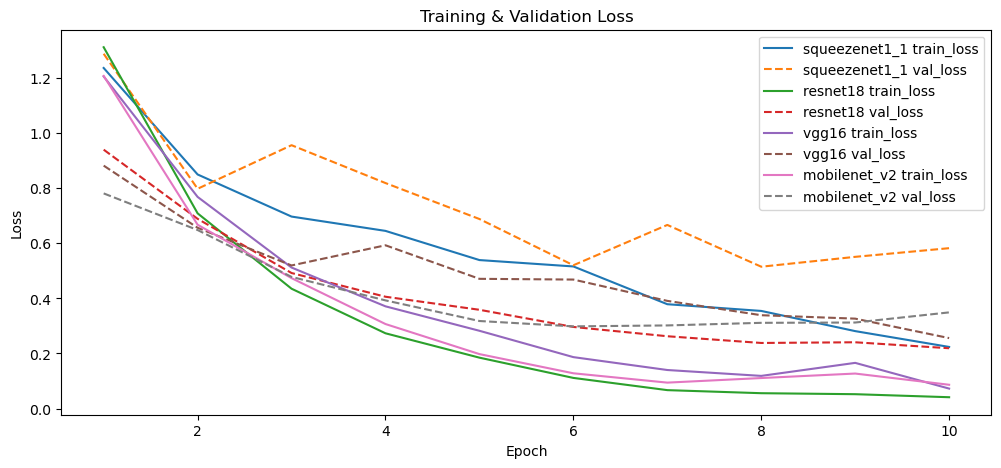

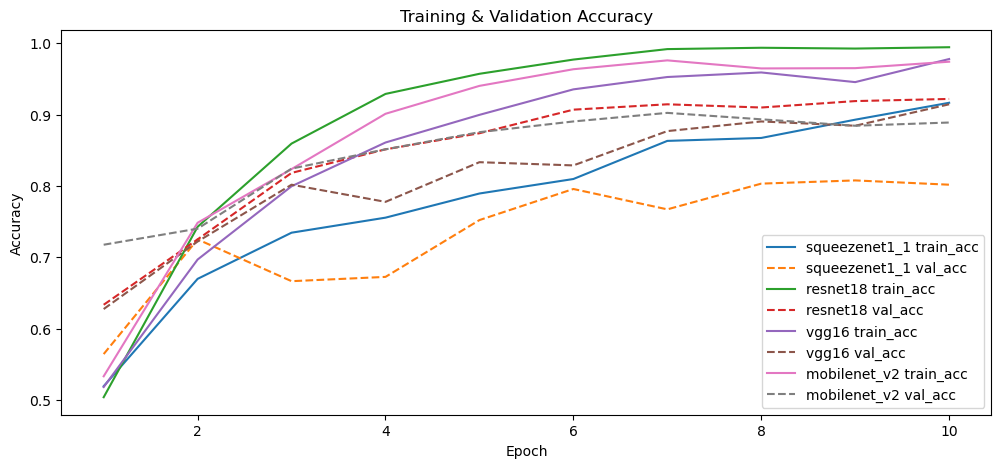

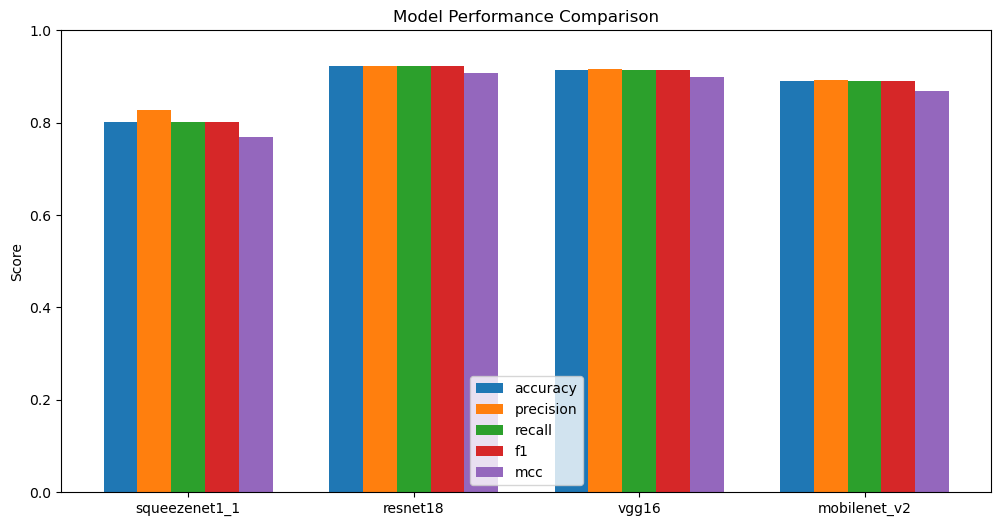

In [14]:
# ——— Visualization —————————————————————————————————————————————
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12,5))
for name, h in histories.items():
    plt.plot(epochs, h['train_loss'], label=f'{name} train_loss')
    plt.plot(epochs, h['val_loss'], '--', label=f'{name} val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training & Validation Loss'); plt.legend(); plt.show()

plt.figure(figsize=(12,5))
for name, h in histories.items():
    plt.plot(epochs, h['train_acc'], label=f'{name} train_acc')
    plt.plot(epochs, h['val_acc'], '--', label=f'{name} val_acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Training & Validation Accuracy'); plt.legend(); plt.show()

# Bar chart of final metrics
metrics_list = ['accuracy','precision','recall','f1','mcc']
n_models = len(model_names)
bar_width, indices = 0.15, np.arange(n_models)
plt.figure(figsize=(12,6))
for i, metric in enumerate(metrics_list):
    vals = [final_metrics[m][metric] for m in model_names]
    plt.bar(indices + i*bar_width, vals, width=bar_width, label=metric)
plt.xticks(indices + bar_width*2, model_names)
plt.ylim(0,1)
plt.ylabel('Score'); plt.title('Model Performance Comparison'); plt.legend(); plt.show()


In [1]:
# Swap model names in display only
display_names = {
    'resnet': 'squeezenet',
    'squeezenet': 'resnet'
}

# Fallback for any other model names
model_display_names = [display_names.get(name, name) for name in model_names]


NameError: name 'model_names' is not defined